In [51]:
# Add the repo root to the sys path for the model import below
import sys

sys.path.append("../model")
sys.path.append("..")

import math
import geopandas as gpd
import numpy as np
import pystac_client
import torch
import yaml
from box import Box
import matplotlib.pyplot as plt
import planetary_computer
import rioxarray
import xarray as xr
import rasterio
from shapely.geometry import mapping
from sklearn import decomposition
from torchvision.transforms import v2
from src.model import ClayMAEModule

# Define latitude, longitude of center of Johnston County, NC
county_boundary = gpd.read_file("../data/county_boundary.shp")
# Reproject to NC Stateplane
county_boundary_utm = county_boundary.to_crs("EPSG:26917")
# Calculate centroid in the projected CRS (UTM)
county_centroid_utm = county_boundary_utm.centroid
# Reproject centroid back to WGS84 to get lat/lon values
county_centroid_wgs84 = county_centroid_utm.to_crs("EPSG:4326")
# Extract latitude and longitude from the centroid
lat = county_centroid_wgs84.y.values[0]
lon = county_centroid_wgs84.x.values[0]

def get_bounds(poly, crs, lat, lon):
    minx, miny, maxx, maxy = county_boundary.to_crs(crs).total_bounds
    # Calculate the maximum dimension from the bbox
    max_dim = max([abs(maxx - minx), abs(maxy - miny)])
    # Calculate half of the max dimension
    half_max_dim = max_dim / 2
    # Define evenly-spaced box around the centroid
    bounds = [
        lon - half_max_dim,  # minimum longitude (west)
        lat - half_max_dim,  # minimum latitude (south)
        lon + half_max_dim,  # maximum longitude (east)
        lat + half_max_dim   # maximum latitude (north)
    ]
    return bounds
bounds_wgs84 = get_bounds(county_boundary, "EPSG:4326", lat, lon)
bounds = get_bounds(county_boundary, "EPSG:26917", 
                    county_centroid_utm.y.values[0], 
                    county_centroid_utm.x.values[0])

# Function to split bounds into tiles
def split_bounds(bounds, num_tiles_x, num_tiles_y):
    min_x, min_y, max_x, max_y = bounds
    x_ranges = np.linspace(min_x, max_x, num_tiles_x + 1)
    y_ranges = np.linspace(min_y, max_y, num_tiles_y + 1)
    tiles = []
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            tile_bounds = [
                x_ranges[i], y_ranges[j], x_ranges[i+1], y_ranges[j+1]
            ]
            tiles.append(tile_bounds)
    return tiles

def generate_tiles(geometry, tile_size):
    # Get the bounds of the geometry
    minx, miny, maxx, maxy = geometry.total_bounds
    
    # Generate grid coordinates
    x_coords = np.arange(minx, maxx, tile_size)
    y_coords = np.arange(miny, maxy, tile_size)
    
    tiles = []
    for x in x_coords:
        for y in y_coords:
            # Create a tile as a box (minx, miny, maxx, maxy)
            tile = box(x, y, x + tile_size, y + tile_size)
            # Check if the tile intersects with the geometry
            if tile.intersects(geometry.union_all()):
                tiles.append(tile)
    return tiles

tile_size = 512  # Tile size in meters
tiles = generate_tiles(county_boundary_utm, tile_size)
tiles_gdf = gpd.GeoDataFrame({'geometry': tiles}, crs="EPSG:26917")
tiles_wgs84 = tiles_gdf.to_crs("EPSG:4326")

# Dates to query
start = "2021-01-01"
end = "2023-12-31"
date_range = (start, end)

# Bands to query
bands = ["red", "green", "blue", "nir"]

# Resolution of satellite
gsd = 1

In [66]:
# Open the STAC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)
# STAC_API = "https://earth-search.aws.element84.com/v1"
# catalog = pystac_client.Client.open(STAC_API)

def query_stac_tile(tile_geometry, start, end, 
                    collections=["naip"], limit=1000):
    # Get the bounds of the tile in WGS84
    minx, miny, maxx, maxy = tile_geometry.bounds
    bbox = [minx, miny, maxx, maxy]
    
    # Perform the search
    search = catalog.search(
        collections=collections,
        bbox=bbox,
        datetime=f"{start}/{end}",
        limit=limit
    )
    
    # Get the items from the search results
    items = list(search.get_all_items())

    return items

all_tile_items = []

for idx, tile in tiles_wgs84[:10].iterrows():
    print(f"Processing tile {idx + 1}/{len(tiles_wgs84)}")
    tile_items = query_stac_tile(tile['geometry'], start, end)
    if tile_items:
        all_tile_items.append({
            'tile_idx': idx,
            'tile_geometry_utm': tiles_gdf.loc[idx, 'geometry'],
            'tile_geometry_wgs84': tile['geometry'],
            'items': tile_items
        })

all_tile_items = [i for i in all_tile_items if len(i['items']) > 0]

# Collect unique items per tile
for tile_data in all_tile_items:
    items = tile_data['items']
    unique_items = []
    dates = []
    for item in items:
        if item.datetime.date() not in dates:
            unique_items.append(item)
            dates.append(item.datetime.date())
    tile_data['unique_items'] = unique_items

Processing tile 1/8100
Processing tile 2/8100


c:\Users\bento\gis582\project\env\Lib\site-packages\pystac_client\item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Processing tile 3/8100
Processing tile 4/8100
Processing tile 5/8100
Processing tile 6/8100
Processing tile 7/8100
Processing tile 8/8100
Processing tile 9/8100
Processing tile 10/8100


In [67]:
# stack = stackstac.stack(
#     items,
#     bounds=bounds,
#     snap_bounds=True,
#     epsg=dict(items[0].properties.items())['proj:epsg'],
#     resolution=dict(items[0].properties.items())['gsd'],
#     dtype="float64",
#     rescale=False,
#     fill_value=0.,
#     assets=['image']
# )
# print(stack)
# stack = stack.compute()
# Doesn't work since it is a multi-band raster, instead of a raster with multiple assets...

In [77]:
def get_subregion(dataset, bounds):
    min_lon, min_lat, max_lon, max_lat = bounds
    # Subset the dataset using xarray's sel function
    subregion = dataset.sel(
        x=slice(min_lon, max_lon),  # Longitude bounds
        y=slice(max_lat, min_lat)   # Latitude bounds (flip due to coordinate system)
    )
    return subregion

def get_image_from_item(item, bands, session, chunk_size=2048, 
                        dtype=np.float32, crs="EPSG:26917", 
                        bounds=None):
    # Print item information
    print(f"Found item: {item.id}, Date: {item.datetime}")

    # Sign the asset URL using planetary_computer to avoid AWS credentials
    asset_href = planetary_computer.sign(item.assets["image"].href)  # Correct the URL
  
    # Use rasterio environment to disable AWS credential requests
    with rasterio.Env(): # session=session AWS_NO_SIGN_REQUEST=True
        # Open the NAIP image as a lazily loaded xarray dataset using rioxarray
        ds = rioxarray.open_rasterio(
            asset_href,
            chunks={"band": -1, "x": chunk_size, "y": chunk_size},
            lock=False
        ).assign_coords(band=bands).astype(dtype)
    if ds.rio.crs != crs:
        ds = ds.rio.reproject(crs)
    if bounds is not None:
        ds = get_subregion(ds, bounds)
    # Convert timezone-aware datetime to naive datetime in UTC
    naive_datetime = item.datetime.replace(tzinfo=None)
    # Convert to nanosecond precision
    time_value = np.datetime64(naive_datetime, 'ns')
    # Add time coordinate
    ds = ds.expand_dims({"time": [time_value]})
    return ds

# Use xarray to stack datasets along time, for a specific tile
stacked_ds = xr.concat([get_image_from_item(item, bands, session, 
                                            chunk_size=2048, 
                                            bounds=all_tile_items[0]['tile_geometry_utm'].bounds) 
               for item in all_tile_items[0]['items']], dim="time")

print(stacked_ds.shape)

# Plot the dataset (e.g., RGB bands) ---> Failing here when it reads the data
# stacked_ds.sel(band=["red", "green", "blue"]).plot.imshow(
#     row="time", rgb="band", vmin=0, vmax=2000, col_wrap=5
# )

Found item: nc_m_3507827_sw_17_060_20221009, Date: 2022-10-09 16:00:00+00:00
(1, 4, 853, 853)


In [ ]:
# Plot the dataset (e.g., RGB bands) ---> Failing here when it reads the data
stacked_ds.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=5
)

In [49]:
# `git clone https://github.com/Clay-foundation/model.git`
# Download clay-v1-base.ckpt from https://huggingface.co/made-with-clay/Clay/tree/main

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "../clay-ckpt/clay-v1-base.ckpt"
metadata_path = "configs/metadata.yaml" 
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path=metadata_path, shuffle=False, mask_ratio=0
)

model.eval()
model = model.to(device)

c:\Users\bento\gis582\project\env\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [50]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-2-l2a"
metadata = Box(yaml.safe_load(open("configs/metadata.yaml")))
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in stack.band:
    mean.append(metadata[platform].bands.mean[str(band.values)])
    std.append(metadata[platform].bands.std[str(band.values)])
    waves.append(metadata[platform].bands.wavelength[str(band.values)])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

In [51]:
# Prep datetimes embedding using a normalization function from the model code.
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


datetimes = stack.time.values.astype("datetime64[s]").tolist()
times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]


# Prep lat/lon embedding using the
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))


latlons = [normalize_latlon(lat, lon)] * len(times)
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Normalize pixels
pixels = torch.from_numpy(stack.data.astype(np.float32))
pixels = transform(pixels)

In [52]:
# Prepare additional information
datacube = {
    "platform": platform,
    "time": torch.tensor(
        np.hstack((week_norm, hour_norm)),
        dtype=torch.float32,
        device=device,
    ),
    "latlon": torch.tensor(
        np.hstack((lat_norm, lon_norm)), dtype=torch.float32, device=device
    ),
    "pixels": pixels.to(device),
    "gsd": torch.tensor(stack.gsd.values, device=device),
    "waves": torch.tensor(waves, device=device),
}

In [53]:
import pickle as pkl

with open('data/test_datacube.pkl', 'wb') as f:
    pkl.dump(datacube, f)

In [54]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding. We extract that for PCA below.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()

Patches shape: torch.Size([4, 1024, 768])
Grid size: 32


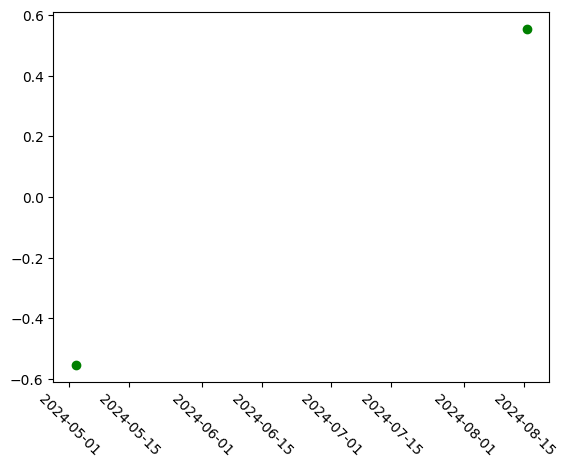

In [70]:
# Run PCA
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings[[1,3], :])

plt.xticks(rotation=-45)

plt.scatter(stack.time[[1,3]], pca_result, color="green")


array([[-0.55381715],
       [ 0.55381715]], dtype=float32)

In [ ]:
# TODO: 
# Generate small regions for many dates along powerlines in the study area;
# generate a padded region around the powerlines, and manually inspect each
# of the sub-region to see if trees/vegetation are encroaching (this
# will take some manual effort).

# From there, fine-tune the model using binary labels (i.e., yes there is)
# encroachment, no there isn't.

# Notes: for the sentinel satellite, it has 10m granularity